In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from laspy.file import File

# Necessary to import pypwaves_updated.py from parent directory
import sys
sys.path.append('../')
import pypwaves_updated as pw

%matplotlib inline

## Comparing with LAS file
GPS timestamps kind of line up...the overall timeframe is identical to ~5 digits, but the offset is very different and the points don't line up exactly.  Also the point counts don't align, even accounting for pulses with multiple returns in the .las file.

In [2]:
# Load LAS points and header
las_df = pd.read_pickle("../../Data/parking_lot/las_points_172753.pkl")
las_header = File('../../Data/164239/10552_NYU_M2 - Scanner 1 - 190511_164239_1 - originalpoints.las', mode='r')

# Load pls anchor points and header
pls_anchor_df = pd.read_pickle("../../Data/pickles/anchors_172753.pkl")
pls_filename = "../../Data/164239/10552_NYU_M2_Pulse_Waves_MTA_Resolved - Scanner 1 - 190511_164239_1 - originalpoints.pls"
pls_header = pw.openPLS(pls_filename)

# Adj GPS Time: Set both timestamps to zero for the first record
las_df['adj_gps_time'] = las_df['gps_time'] - las_df['gps_time'].min()
pls_anchor_df['adj_gps_time'] = pls_anchor_df['gps_time']- pls_anchor_df['gps_time'].min()

# Sort records by timestamp
las_df.sort_values(by=['adj_gps_time'],inplace=True)
pls_anchor_df.sort_values(by=['adj_gps_time'],inplace=True)

# Reset indices
las_df.reset_index(drop=True,inplace=True)
pls_anchor_df.reset_index(drop=True,inplace=True)

In [3]:
# Separate out the first returns only
las_df['num_returns'] = np.floor(las_df['flag_byte']/16).astype(int)
las_df['return_num'] = las_df['flag_byte']%16
first_return_df = las_df[las_df['return_num']==1]
first_return_df = first_return_df.reset_index(drop=True)

In [ ]:
print("Number of points in .las file: {:,d}".format(las_df.shape[0]))
print("Number of first return points: {:,d}".format(first_return_df.shape[0]))
print("Number of pulses in .pls file: {:,d}".format(pls_anchor_df.shape[0]))

### Comparing Timestamps
The count of points don't agree: LAS file has 25-50% more points.  Multiple returns per point account for some but not all the discrepancy.

However, the time ranges for the two files agree almost exactly.  Below, we try to line up these timestamps, but are generally unsuccessful.

In [ ]:
# Compare time ranges
las_range = (first_return_df['gps_time'].min(),first_return_df['gps_time'].max())
anchor_range = (pls_anchor_df['gps_time'].min(),pls_anchor_df['gps_time'].max())

print("LAS range: {:2.3f} seconds".format(las_range[1]-las_range[0]))
print("PLS range: {:2.3f} seconds".format(anchor_range[1]-anchor_range[0]))

In [ ]:
# The timestamps just don't line up very often.
print("count \t PLS time\t LAS time")
offset = 41282
for i in range(100020,100021):
    print("{:d}:      {:2.6f}\t {:2.6f}".format(i,pls_anchor_df['adj_gps_time'][i], 
                                                first_return_df['adj_gps_time'][i+offset]))

In [ ]:
# Checking the GPS encoding for LAS file - Type 0 indicates GPS Week Time, otherwise GPS Adjusted Time.
# This seems to mean GPS Week Time
#print("LAS time type: ",las_header.header.get_gps_time_type())

print("\nLAS:")
print("GPS Time at start of run: {:2.3f} days".format(las_range[1]/ (60*60*24)))
# So the run was probably on a Sunday?
print("\nPLS:")
print("GPS Time at start of run: {:2.3f} days".format(anchor_range[0]/(60*60*24)))

### Timestamps - Analysis
Both systems could be on GPS Week time, in terms of order of magnitude of the values (both under 7 days), but they differ by 6 days.  I also haven't found any indication of when specifically the timestamp refers to: When the pulse was emitted, when it was received, "when" the point is, accounting for the time to the point itself, etc.

#### Idea: 
The difference could be that the pls file uses emit time and the point file adds the time to/from the point.

In [ ]:
# plt.figure(figsize=(20,30))
# plt.subplot(4, 1, 1)
# plt.plot(las_df['x_scaled'][1390:1408])

# plt.subplot(4, 1, 2)
# plt.plot(las_df['y_scaled'][1390:1408])

# plt.subplot(4, 1, 3)
# plt.plot(las_df['z_scaled'][1390:1408])

# plt.subplot(4, 1, 4)
# plt.plot(las_df['intensity'][1390:1408])

## Extract points with no corresponding pulse
Points that don't have a pulse within $\pm \epsilon$ seconds.

In [4]:
print("first_return_df.shape: ",first_return_df.shape)
print("pls_anchor_df.shape: ",pls_anchor_df.shape)

first_return_df.shape:  (10968702, 17)
pls_anchor_df.shape:  (9089361, 5)


In [5]:
# For each point, find the pulse at the closest 
# previous (or equal) timestamp
pls_indices = np.searchsorted(pls_anchor_df['adj_gps_time'],
                             first_return_df['adj_gps_time'])-1

In [6]:
# Only the nearest point can associate with a given pulse.
pls_indices[0] = 0
for i,pls in enumerate(pls_indices[1:]):
    if pls_indices[i] == pls_indices[i-1]:
        pls_indices[i] = 0

In [7]:
# Calculate time difference between each point and closest pulse
epsilon = .000001 # This is too loose, but it works for just looking at points that clearly have no pulse.
time_diff = np.array(first_return_df['adj_gps_time']) - \
            np.array(pls_anchor_df['adj_gps_time'].iloc[pls_indices])

# If time difference > epsilon, set pls_index to zero
for i,t in enumerate(time_diff):
    if t > epsilon:
        pls_indices[i] = 0

In [8]:
first_return_df['pulse_index'] = pls_indices
no_pulse = first_return_df[first_return_df['pulse_index']==0]
with_pulse = first_return_df[first_return_df['pulse_index']>0]

In [ ]:
print("Fraction of points without a corresponding pulse: {:2.4f}".format(sum(pls_indices==0)/pls_indices.shape[0]))

In [ ]:
no_pulse.describe()

In [ ]:
with_pulse.describe()

In [ ]:
plt.plot(no_pulse['adj_gps_time'][:2000],no_pulse['z_scaled'][:2000],'x')

In [ ]:
plt.plot(with_pulse['adj_gps_time'][:2000],with_pulse['z_scaled'][:2000],'x')

## Temporal Distribution
Tooling, then comparing temporal distribution of points with and without a corresponding pulse.

In [9]:
# Bins are every 10 miliseconds.
ms_per_bin = 50
def create_bins(df,ms_per_bin,time_field='adj_gps_time'):
    '''Function returns a numpy array of bin edges, 
    where the number of bins = (max_time - min_time)*1e/ms_per_bin 
    where time is in seconds.'''
    min_val = int(np.floor(df[time_field].min())*1e3)
    max_val = int(np.ceil(df[time_field].max())*1e3)
    bin_range = range(min_val,max_val,ms_per_bin)
    bin_arr = np.array(bin_range)/1e3
    return bin_arr

In [10]:
# Create the bin edges
bin_arr = create_bins(first_return_df,ms_per_bin)
# Use np.histogram to find the number of points per bin
hist,_ = np.histogram(first_return_df['adj_gps_time'],bin_arr)
hist_no_pulse,_ = np.histogram(no_pulse['adj_gps_time'],bin_arr)
hist_with_pulse,_ = np.histogram(with_pulse['adj_gps_time'],bin_arr)

Text(0.5, 1.0, 'Points without a pulse')

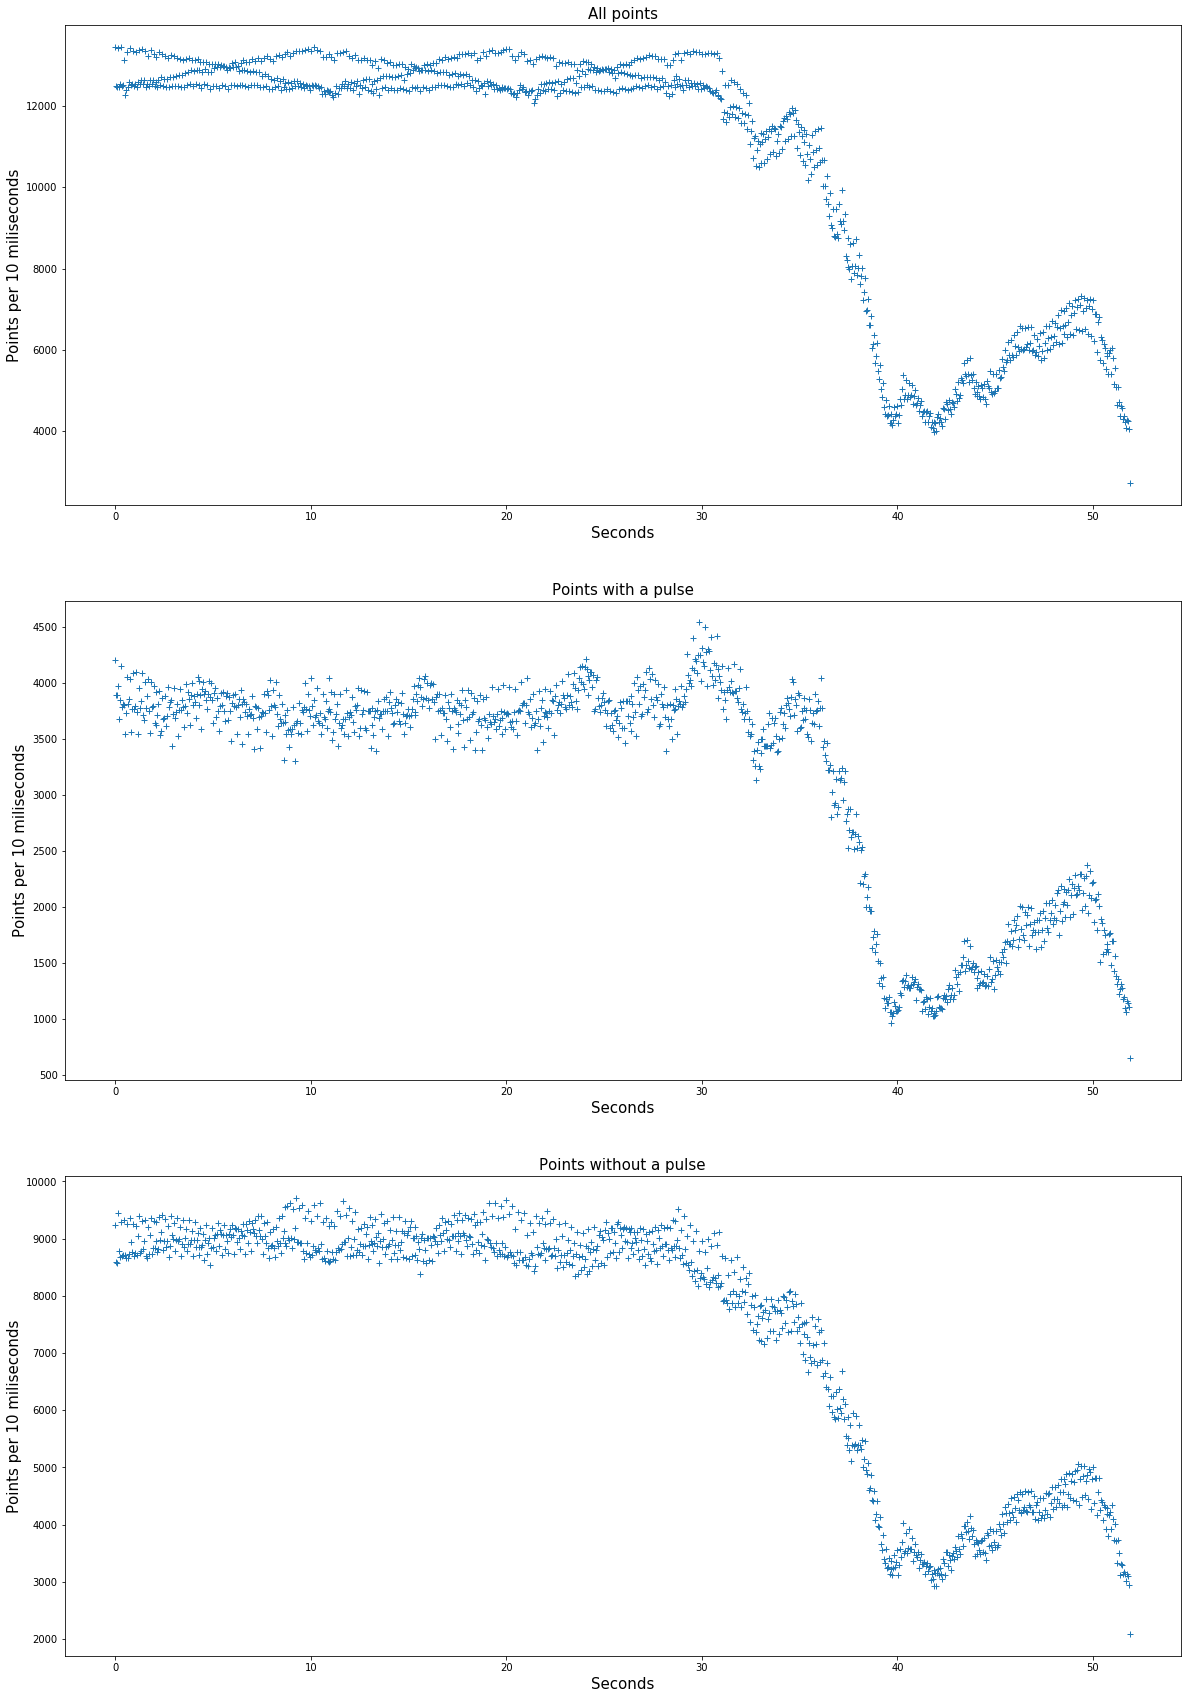

In [11]:
plt.figure(figsize=(20,30))
plt.subplot(3, 1, 1)
plt.plot(bin_arr[:-1],hist,'+')
plt.xlabel("Seconds",fontsize=15)
plt.ylabel("Points per 10 miliseconds",fontsize=15)
plt.title("All points",fontsize=15)

plt.subplot(3, 1, 2)
plt.plot(bin_arr[:-1],hist_with_pulse,'+')
plt.xlabel("Seconds",fontsize=15)
plt.ylabel("Points per 10 miliseconds",fontsize=15)
plt.title("Points with a pulse",fontsize=15)

plt.subplot(3, 1, 3)
plt.plot(bin_arr[:-1],hist_no_pulse,'+')
plt.xlabel("Seconds",fontsize=15)
plt.ylabel("Points per 10 miliseconds",fontsize=15)
plt.title("Points without a pulse",fontsize=15)

Text(0.5, 1.0, 'Temporal distribution of points from one flight')

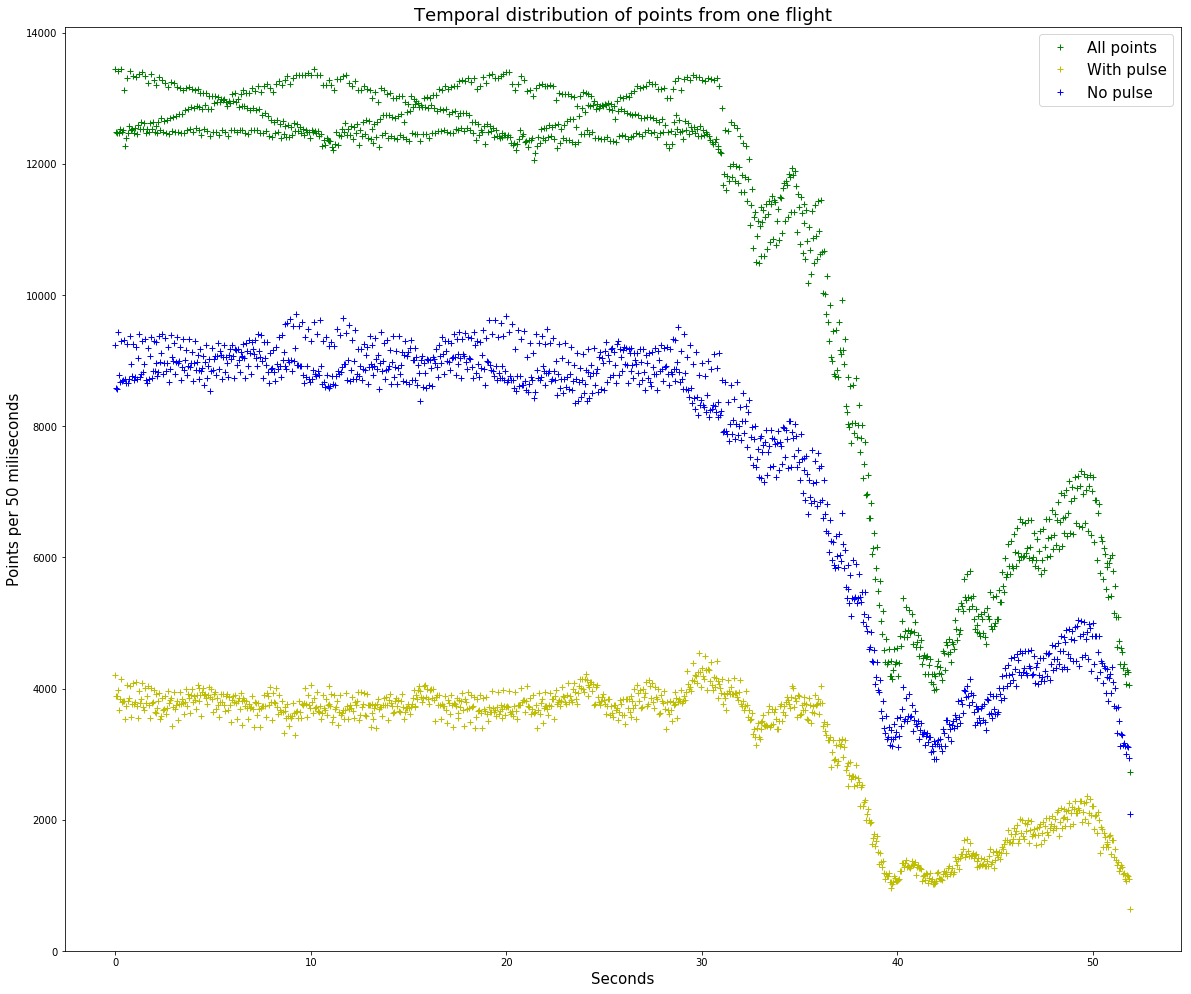

In [12]:
plt.figure(figsize=(20,17))

plt.plot(bin_arr[:-1],hist,'g+',label="All points")
plt.plot(bin_arr[:-1],hist_with_pulse,'y+',label="With pulse")
plt.plot(bin_arr[:-1],hist_no_pulse,'b+',label="No pulse")

plt.xlabel("Seconds",fontsize=15)
plt.ylabel("Points per 50 miliseconds",fontsize=15)
plt.legend(fontsize=15)
plt.title("Temporal distribution of points from one flight",fontsize=18)

In [ ]:
plt.figure(figsize=(20,17))

plt.plot(bin_arr[:-1],hist,'g+',label="All points")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Seconds",fontsize=15)
plt.ylabel("Points per 50 miliseconds",fontsize=15)
plt.title("Temporal distribution of points from one flight",fontsize=18)